# *A Bayesian workflow for mitigation analysis and decision making with epidemiological models*

This notebook contains all of the code used to produce the results and figures included in the paper

## Setting: Washington State -- July 31, 2021 (Delta Wave)

### Load dependencies

In [1]:
import os
import json
import sympy
import torch
import numpy as np
import pandas as pd
from typing import Dict, List, Callable

# MIRA modeling dependencies
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file

# PyCIEMSS dependencies
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

## Data processing

Hospitalization and ICU data from [Washington State Respiratory Illness Data Dashboard](https://doh.wa.gov/data-and-statistical-reports/diseases-and-chronic-conditions/communicable-disease-surveillance-data/respiratory-illness-data-dashboard#downloads)

*Note that patients in the ICU are also counted as hospitalized.

Death data from [COVID-19 Forecast Hub](https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/README.md)

### Process death data

In [2]:
# location = "Washington"
# data_start_date = '2021-06-15'
# data_end_date = '2021-08-15'

# # BETTER_NAMES = {'Cases': 'Infected',
# #                 'COVID19 7 day Avg Hospitalizeditalizations': 'COVID19 7 day Avg Hospitalizeditalized',
# #                 'Deaths': 'Dead'}
# # ## instantiate, making sure no dates are skipped between start and end (could be found dynamically)
# # full_dataset = pd.DataFrame({'date':pd.date_range(start='1/22/2020', end='3/29/2024')})

# # ## fill the instantiated dataset
# # for i in ['Cases','COVID19 7 day Avg Hospitalizeditalizations','Deaths']:
# #     all_data = pd.read_csv(f'https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20{i}.csv')
# #     subset   = all_data[all_data.location_name == location].groupby("date")["value"].sum().reset_index()
# #     subset.date = pd.to_datetime(subset.date)
# #     subset['cumsum'] = subset.value.cumsum()
# #     full_dataset = full_dataset.merge(subset[['date','cumsum']], how='outer', on='date').rename(columns={'cumsum':BETTER_NAMES[i]})

# # full_dataset[(full_dataset.date >= '2021-06-01') & (full_dataset.date < '2021-09-06')].reset_index(drop=True).reset_index(names=['Timestamp']).drop(['date'],axis=1)

# # # Save full dataset
# # full_dataset.to_csv('full_dataset.csv', index=False)

# # Read full dataset
# full_dataset = pd.read_csv('full_dataset.csv')

# ## Define a function to select a subset of the data
# def get_data_between(start=data_start_date,end=data_end_date):
#     return full_dataset[(full_dataset.date >= start) & (full_dataset.date < end)].reset_index(drop=True).reset_index(names=['Timestamp']).drop(['date'],axis=1)

### Process hospitalization data

In [3]:
# # Step 1: Read the CSV file into a pandas DataFrame
# # Assume CSV has columns: 'Date Range Start', 'COVID19 7 day Avg Hospitalized', and 'COVID19 7 day AVG in ICU bed'
# df = pd.read_csv('wahealth_hospitaluse.csv')

# # Convert the 'Date Range Start' column to datetime if it's not already
# df['Date Range Start'] = pd.to_datetime(df['Date Range Start'])

# # Step 2: Create a date range that includes all the days
# min_date = df['Date Range Start'].min()
# max_date = df['Date Range Start'].max() + pd.Timedelta(days=6)  # include last week completely
# date_range = pd.date_range(start=min_date, end=max_date, freq='D')

# # Step 3: Create a full DataFrame with the complete date range
# full_df = pd.DataFrame(date_range, columns=['date'])
# full_df.set_index('date', inplace=True)

# # Step 4: Assign weekly averages to the corresponding start dates
# full_df['COVID19 7 day Avg Hospitalized'] = np.nan
# full_df['COVID19 7 day AVG in ICU bed'] = np.nan

# full_df.loc[df['Date Range Start'], 'COVID19 7 day Avg Hospitalized'] = df['COVID19 7 day Avg Hospitalized'].values
# full_df.loc[df['Date Range Start'], 'COVID19 7 day AVG in ICU bed'] = df['COVID19 7 day AVG in ICU bed'].values

# # Step 5: Interpolate to fill in the missing daily values
# full_df['COVID19 7 day Avg Hospitalized'] = full_df['COVID19 7 day Avg Hospitalized'].interpolate(method='polynomial', order=3)
# full_df['COVID19 7 day AVG in ICU bed'] = full_df['COVID19 7 day AVG in ICU bed'].interpolate(method='polynomial', order=3)

# # Optional: Reset the index to get 'date' back as a column
# full_df.reset_index(inplace=True)

# # Step 1: Select data between May 31, 2021 and July 31, 2021
# mask = (full_df['date'] >= data_start_date) & (full_df['date'] <= data_end_date)
# filtered_df = full_df.loc[mask]

# # Step 2: Rename the columns
# filtered_df.rename(columns={
#     'COVID19 7 day Avg Hospitalized': 'hosp',
#     'COVID19 7 day AVG in ICU bed': 'icu'
# }, inplace=True)

# # Step 3: Delete the date column
# filtered_df.drop(columns=['date'], inplace=True)

# # Step 4: Rename the index column to `Timestamp`
# filtered_df.reset_index(drop=True, inplace=True)  # Drop the current index
# filtered_df.index.name = 'Timestamp'

# # Collect death data
# cumulative_data = get_data_between()

# # Add 'dead' column from df1 to df2
# filtered_df['dead'] = cumulative_data['Dead']

# # Print the updated DataFrame
# print(filtered_df.head())

# # Save the resulting DataFrame to a new CSV file
# filtered_df.to_csv('wa_hosp_death_data.csv')

## Gather population values and initial conditions

Population values from [Census Reporter - Washington State](https://censusreporter.org/profiles/04000US53-washington/)

Initial conditions estimated from [COVID-19 Forecast Hub (CFH)](https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/README.md) and [Washington State Department of Health Respiratory Illness Data Dashboard](https://doh.wa.gov/data-and-statistical-reports/diseases-and-chronic-conditions/communicable-disease-surveillance-data/respiratory-illness-data-dashboard#Vaccination)

In [4]:
WA_state_total_pop = 7_785_786 # US Census Bureau
initial_vacc = 675_796 # Vaccinated June 2021, from WA State Dept. of Health
vacc_efficacy = 0.87 # Vaccination efficacy against transmission for Delta variant, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10073587/
initial_deaths = 5800.0 # 06/01/2021, from NYT data
initial_hosp = 310.0 # 06/01/2021, from WA State Dept. of Health
initial_icu = 97.0 # 06/01/2021, from WA State Dept. of Health
initial_recovered = 442_815.0 # Estimate of recovered population = cumulative cases 05/25/2021, from CFH data 
initial_cases = 445_155.0 - 442_815.0 # Estimate of active cases 06/01/2021, from CFH data
initial_exposed = 2*initial_cases # Estimate of exposed population 06/01/2021
initial_susceptible = WA_state_total_pop - (initial_deaths + initial_hosp + initial_recovered + initial_vacc + initial_cases + initial_exposed)

# Model derivation and initialization

### Define units

In [5]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

### Define model concepts

In [6]:
c = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}), # Susceptible
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '00000154'}), # Exposed
    'I': Concept(name='I', units=person_units(), identifiers={'ido': '0000511'}), # Infectious
    'R': Concept(name='R', units=person_units(), identifiers={'ido': '0000592'}), # Recovered
    
    'H': Concept(name="H", units=person_units(), identifiers={"ido": "0000511"},
                        context={"property": "ncit:C25179"}), # Hospitalized
    'U': Concept(name="U", units=person_units()), # Hospitalized in ICU
    'V': Concept(name="V", units=person_units()), # Vaccinated
    'D': Concept(name="D", units=person_units(), identifiers={"ncit": "C28554"}), # Deceased
}

for concept in c:
    c[concept].name = concept

### Define model parameters with uncertainty

Death rates among hospitalized https://www.cdc.gov/nchs/covid19/nhcs/hospital-mortality-by-week.htm

In [7]:
parameters = {
    'beta': Parameter(name='beta', value=sympy.Float(0.085), units=per_day_units(),
                      distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.075,
                                                            'maximum': 0.09})),  # Transmission rate
    'N': Parameter(name='total_population', value=sympy.Float(WA_state_total_pop), units=person_units()),  # Total population
    'vacc_mult': Parameter(name='vacc_mult', value=sympy.Float(1 - vacc_efficacy), units=person_units()),  # Transmission for vaccinated
    
    'r_EI': Parameter(name='r_EI', value=sympy.Float(0.167), units=per_day_units(),
                     distribution=None),  # Rate of progressing E -> I, (Latency period)^-1
    
    'r_IR': Parameter(name='r_IR', value=sympy.Float(0.143), units=per_day_units(),
                 distribution=None),  # Rate of progressing I -> H or R, (Infectious period)^-1

    'p_IH': Parameter(name='p_IH', value=sympy.Float(0.14), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.13,
                                                            'maximum': 0.15})),  # Percent of I -> H

    'p_IU': Parameter(name='p_IU', value=sympy.Float(0.025), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.023,
                                                            'maximum': 0.027})),  # Percent of I -> U
    
    'r_HR': Parameter(name='r_HR', value=sympy.Float(0.222), units=per_day_units(),
                 distribution=None),  # Rate of progressing H -> R 

    'r_UR': Parameter(name='r_UR', value=sympy.Float(0.077), units=per_day_units(),
                 distribution=None),  # Rate of progressing U -> R 
    
    'p_HD': Parameter(name='p_HD', value=sympy.Float(0.09), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.08,
                                                            'maximum': 0.1})),  # Percent H -> D

    'p_UD': Parameter(name='r_UD', value=sympy.Float(0.15), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.14,
                                                            'maximum': 0.17})),  # Percent U -> D

    'r_RS': Parameter(name='r_RS', value=sympy.Float(0.0027), units=per_day_units(),
                 distribution=None),  # Rate of progressing R -> S
    
    'r_V': Parameter(name='r_V', value=sympy.Float(8267.0), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 8000.0,
                                                            'maximum': 8500.0})),  # Rate of progressing S, R -> V

}

### Define `SymPy` variables

In [8]:
S, E, I, R, H, U, V, D, beta, N, vacc_mult, r_EI, r_IR, p_IH, p_IU, r_HR, r_UR, p_HD, p_UD, r_RS, r_V = sympy.symbols(
    'S E I R H U V D beta N vacc_mult r_EI r_IR p_IH p_IU r_HR r_UR p_HD p_UD r_RS r_V ')

### Set initial conditions

In [9]:
initials = {
    "S": Initial(concept=c["S"], expression=initial_susceptible),
    "E": Initial(concept=c["E"], expression=initial_exposed),
    "I": Initial(concept=c["I"], expression=initial_cases),
    "R": Initial(concept=c["R"], expression=initial_recovered),
    'H': Initial(concept=c["H"], expression=initial_hosp-initial_icu),
    'U': Initial(concept=c["U"], expression=initial_icu),
    'V': Initial(concept=c["V"], expression=initial_vacc),
    'D': Initial(concept=c["D"], expression=initial_deaths)
}

### Define templates

In [10]:
##### S -> E
se = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*S*I / N
)

##### V -> E
ve = ControlledConversion(
    subject=c['V'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*vacc_mult*V*I / N
)


#### E -> I
ei = NaturalConversion(
    subject=c['E'],
    outcome=c['I'],
    rate_law=r_EI*E
)


#### I -> R
ir = NaturalConversion(
    subject=c['I'],
    outcome=c['R'],
    rate_law=r_IR*(1 - p_IH - p_IU)*I
)


#### I -> H
ih = NaturalConversion(
    subject=c['I'],
    outcome=c['H'],
    rate_law=r_IR*p_IH*I
)

#### I -> U
iu = NaturalConversion(
    subject=c['I'],
    outcome=c['U'],
    rate_law=r_IR*p_IU*I
)


#### H -> R
hr = NaturalConversion(
    subject=c['H'],
    outcome=c['R'],
    rate_law=r_HR*(1 - p_HD)*H
)


#### H -> D
hd = NaturalConversion(
    subject=c['H'],
    outcome=c['D'],
    rate_law=r_HR*p_HD*H
)

#### U -> R
ur = NaturalConversion(
    subject=c['U'],
    outcome=c['R'],
    rate_law=r_UR*(1 - p_UD)*U
)


#### U -> D
ud = NaturalConversion(
    subject=c['U'],
    outcome=c['D'],
    rate_law=r_UR*p_UD*U
)

#### R -> S
rs = NaturalConversion(
    subject=c['R'],
    outcome=c['S'],
    rate_law=r_RS*R
)

### Vaccination
# R -> V
rv = NaturalConversion(
    subject=c['R'],
    outcome=c['V'],
    rate_law=r_V
)

# S -> V
sv = NaturalConversion(
    subject=c['S'],
    outcome=c['V'],
    rate_law=r_V
)

### Define observables

In [11]:
observables_seir = {
    'cases': Observable(name='cases', expression=I),
    'hospitalized': Observable(name='hospitalized', expression=H+U),
    'icu': Observable(name='icu', expression=U),
    'deceased': Observable(name='deceased', expression=D),
}

### Define template model and save as petrinet AMR

In [12]:
seir_model = TemplateModel(
    templates=[
        se,
        ve,
        ei,
        ir,
        ih,
        iu,
        hr,
        hd,
        ur,
        ud,
        rs,
        rv,
        sv
    ],
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEIRHUVD model')
)

# Save as JSON
with open("SEIRHUVD_base_model.json", 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

# Sample from model prior

### Set model path and parameters for sampling

In [65]:
model1 = "SEIRHUVD_base_model.json"
num_iterations = 500
num_samples = 200
start_time = 0.0
end_time = 100.0
logging_step_size = 1.0

solution_mapping = [lambda x : x]
data_mapping = {'hosp': 'hospitalized', 'icu': 'icu', 'dead': 'deceased'}

dataset = pd.read_csv("wa_hosp_death_data.csv")

### Sample from model prior and plot output

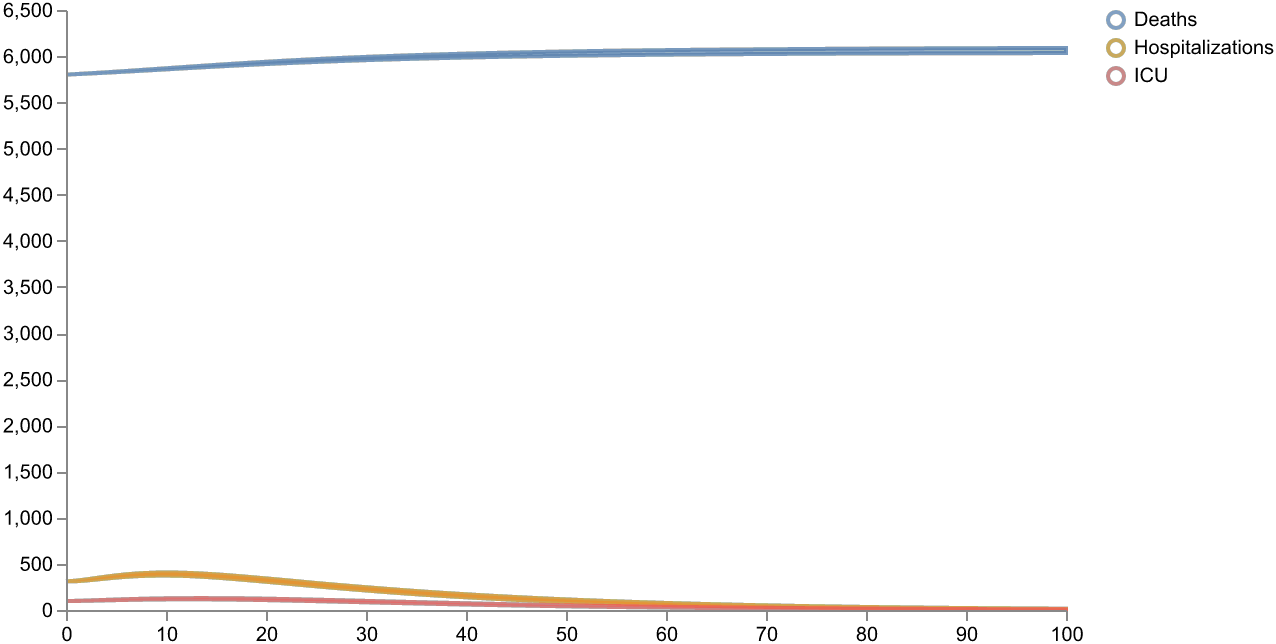

In [63]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for all states
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations", 
        "icu_observable_state": "ICU",
        "deceased_observable_state": "Deaths"
        }

schema = plots.trajectories(
    result1["data"], 
    keep=["hospitalized_observable_state", "icu_observable_state", "deceased_observable_state"],
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Calibrate model to data

In [68]:
calibrated_results1 = pyciemss.calibrate(model1, dataset, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates1 = calibrated_results1["inferred_parameters"]

display(parameter_estimates1())

calibrated_sample_results1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, 
                                            start_time=start_time, inferred_parameters=parameter_estimates1)

{'persistent_beta': tensor(0.0898, grad_fn=<ExpandBackward0>),
 'persistent_p_IH': tensor(0.1498, grad_fn=<ExpandBackward0>),
 'persistent_p_IU': tensor(0.0270, grad_fn=<ExpandBackward0>),
 'persistent_p_HD': tensor(0.0897, grad_fn=<ExpandBackward0>),
 'persistent_p_UD': tensor(0.1453, grad_fn=<ExpandBackward0>),
 'persistent_r_V': tensor(8002.7554, grad_fn=<ExpandBackward0>)}

### Plot the result

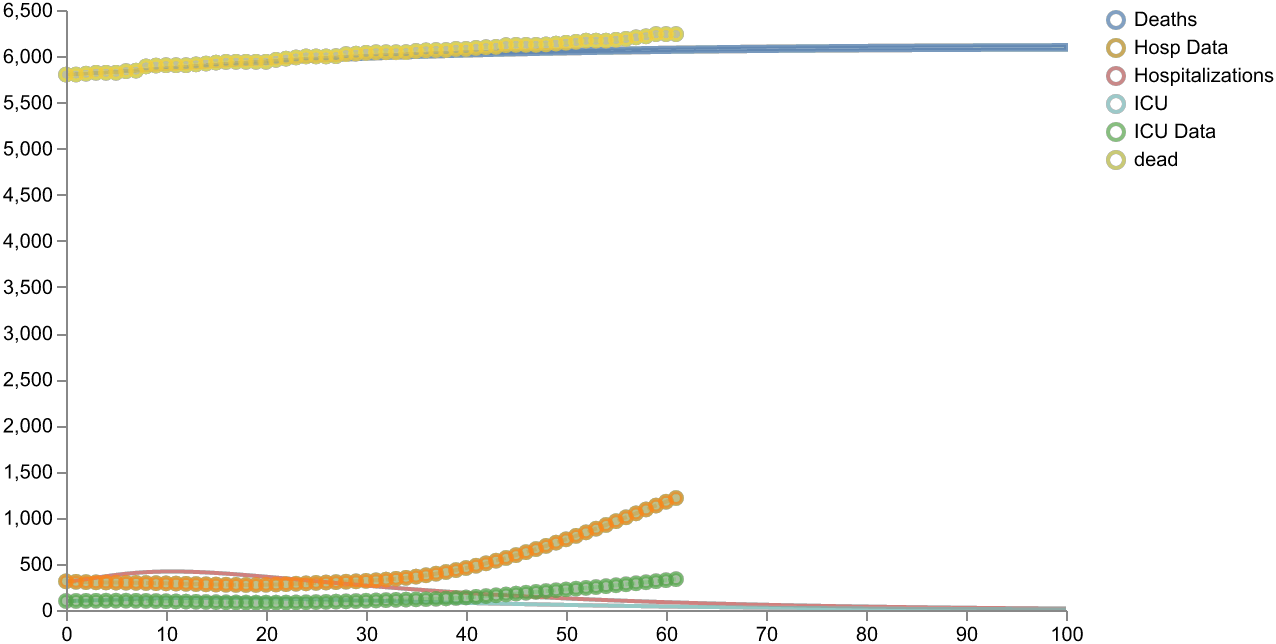

In [67]:
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations", 
        "icu_observable_state": "ICU",
        "deceased_observable_state": "Deaths"
        }
nice_data_names = {
        "hosp": "Hosp Data",
        "icu": "ICU Data",
        "deaths": "Death Data"
        }
data_df = dataset
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(calibrated_sample_results1["data"]), 
    keep=["hospitalized_observable_state", "icu_observable_state", "deceased_observable_state"], 
    relabel=nice_labels,
    points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Calibrate model to data with interventions

In [59]:
mult1 = 3.3
calibrated_results = pyciemss.calibrate(model1, dataset, data_mapping=data_mapping, num_iterations=num_iterations,
                                       static_parameter_interventions = {torch.tensor(30.0): {"beta": lambda x : x*mult1, 
                                                                                              "p_IH": lambda x : x*mult1,
                                                                                              "p_IU": lambda x : x*mult1}})
parameter_estimates = calibrated_results["inferred_parameters"]

display(parameter_estimates())

calibrated_sample_results = pyciemss.sample(model1, end_time, logging_step_size, num_samples, 
                                            start_time=start_time, inferred_parameters=parameter_estimates,
                                           static_parameter_interventions = {torch.tensor(30.0): {"beta": lambda x : x*mult1, 
                                                                                                  "p_IH": lambda x : x*mult1,
                                                                                                  "p_IU": lambda x : x*mult1
                                                                                                 }})
# display(calibrated_sample_results["data"].head())

{'persistent_beta': tensor(0.0842, grad_fn=<ExpandBackward0>),
 'persistent_p_IH': tensor(0.1309, grad_fn=<ExpandBackward0>),
 'persistent_p_IU': tensor(0.0231, grad_fn=<ExpandBackward0>),
 'persistent_p_HD': tensor(0.0901, grad_fn=<ExpandBackward0>),
 'persistent_p_UD': tensor(0.1526, grad_fn=<ExpandBackward0>),
 'persistent_r_V': tensor(8076.6392, grad_fn=<ExpandBackward0>)}

# Plot deaths

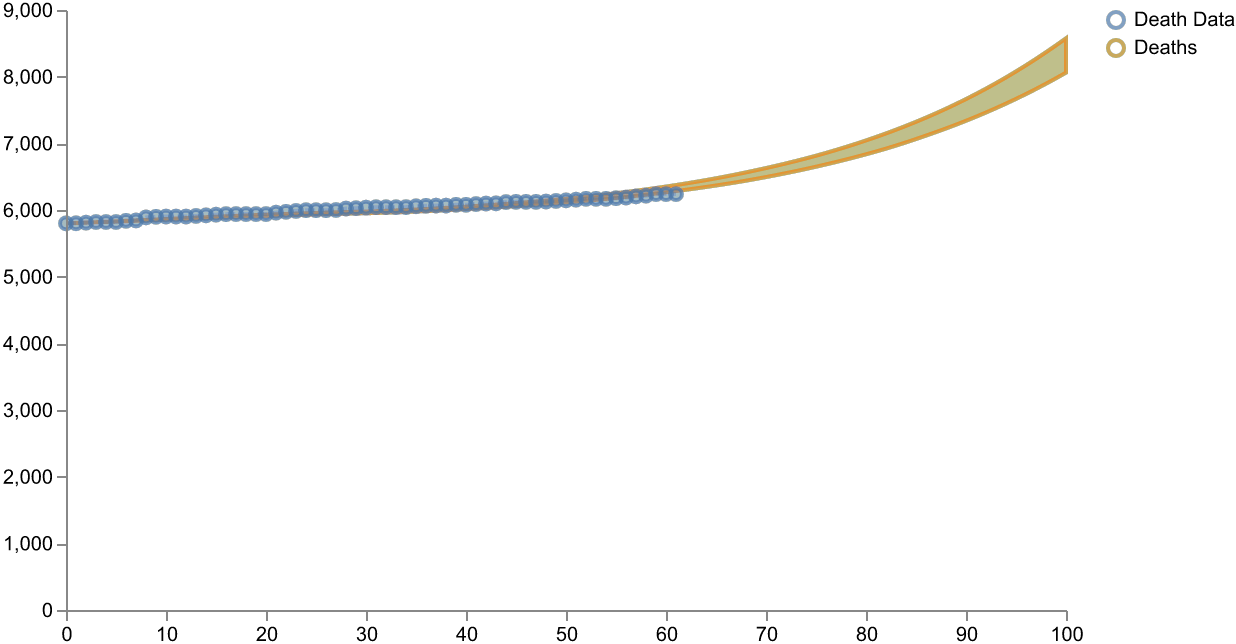

In [60]:
# Plot the result
nice_labels = {
        "deceased_observable_state": "Deaths", 
        }
nice_data_names = {
        "dead": "Death Data"
        }
data_df = dataset
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(calibrated_sample_results["data"]), 
    keep=["deceased_observable_state"], 
    relabel=nice_labels,
    points=data_df.drop(columns=['Timestamp', "Hosp Data", "ICU Data"]).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Plot hospitalizations

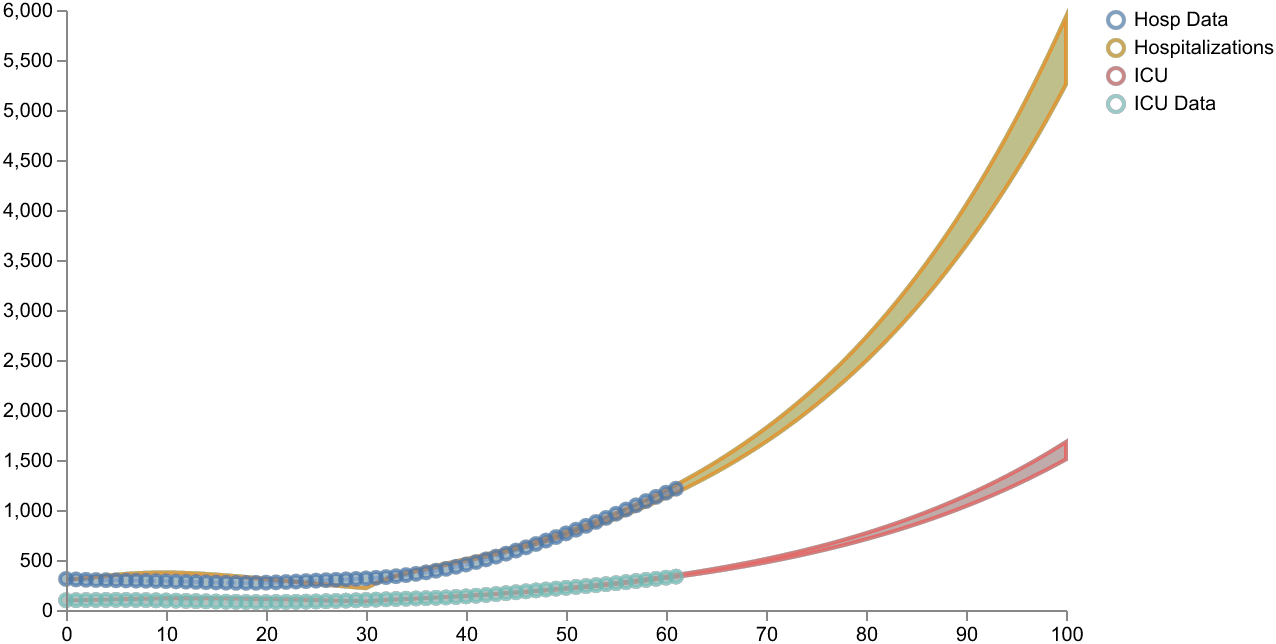

In [61]:
# Plot the result
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations", 
        "icu_observable_state": "ICU",
        }
nice_data_names = {
        "hosp": "Hosp Data",
        "icu": "ICU Data",
        }
data_df = dataset
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(calibrated_sample_results["data"]), 
    keep=["hospitalized_observable_state", "icu_observable_state"], 
    relabel=nice_labels,
    points=data_df.drop(columns=['Timestamp', 'Death Data']).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Find the number of vaccinations per day to keep ICU hospitalizations below X and total hospitalizations below Y

### Set up optimization and define QoI

In [69]:
num_samples_ouu = 100 # controls accuracy of risk estimation in each optimization iteration
maxiter = 3    # maximum number of restarts of local convex optimizer leading to maxiter+1 local optimizations
maxfeval = 30  # maximum number of function evaluations in each instance of local convex optimization

# Define QOI as maximum value over entire simulation
def obs_max_qoi(samples: Dict[str, torch.Tensor], contexts: List) -> np.ndarray:
    """
    Return maximum value over simulated time.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.max(dataQoI, axis=1)

### Perform optimization for number of vaccinations per day

In [82]:
# Define optimization problem setup
observed_params = ["U_state"]
intervention_time = [torch.tensor(61.0)]
intervened_params = ["r_V"]
current_param_value = 8267.0
initial_guess_interventions = 20000
bounds_interventions = [[9000], [90000]]
static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor(x)],
    start_time = intervention_time,
)

risk_bound = 1500.0
qoi = lambda y: obs_max_qoi(y, observed_params)
objfun = lambda x: np.abs(current_param_value - x)

# Run optimize interface
opt_result1 = pyciemss.optimize(
    model1,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    fixed_static_parameter_interventions = {torch.tensor(30.0): {"beta": lambda x : x*mult1, 
                                            "p_IH": lambda x : x*mult1,
                                            "p_IU": lambda x : x*mult1
                                           }},
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
)

print(f'Optimal policy:', opt_result1["policy"])
print(opt_result1)

 83%|██████████████████████████████████████▎       | 100/120 [02:58<00:35,  1.78s/it]

Optimal policy: tensor([17020.2100], dtype=torch.float64)
{'policy': tensor([17020.2100], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 8753.209970446376
                          x: [ 1.702e+04]
                        nit: 3
      minimization_failures: 2
                       nfev: 99
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: 8753.209970446376
                                   x: [ 1.702e+04]
                                nfev: 24
                               maxcv: 0.0}


In [83]:
static_parameter_interventions(opt_result1["policy"])

{61.0: {'r_V': tensor(17020.2109)}}

### Sample with the intervention implemented at the optimal time and plot the results

In [85]:
optimized_result = pyciemss.sample(
    model1,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    static_parameter_interventions={torch.tensor(30.0): {"beta": lambda x : x*mult1,
                                                          "p_IH": lambda x : x*mult1,
                                                          "p_IU": lambda x : x*mult1
                                                          },
                                    torch.tensor(61.0): {"r_V": torch.tensor(17020.21)}}
)

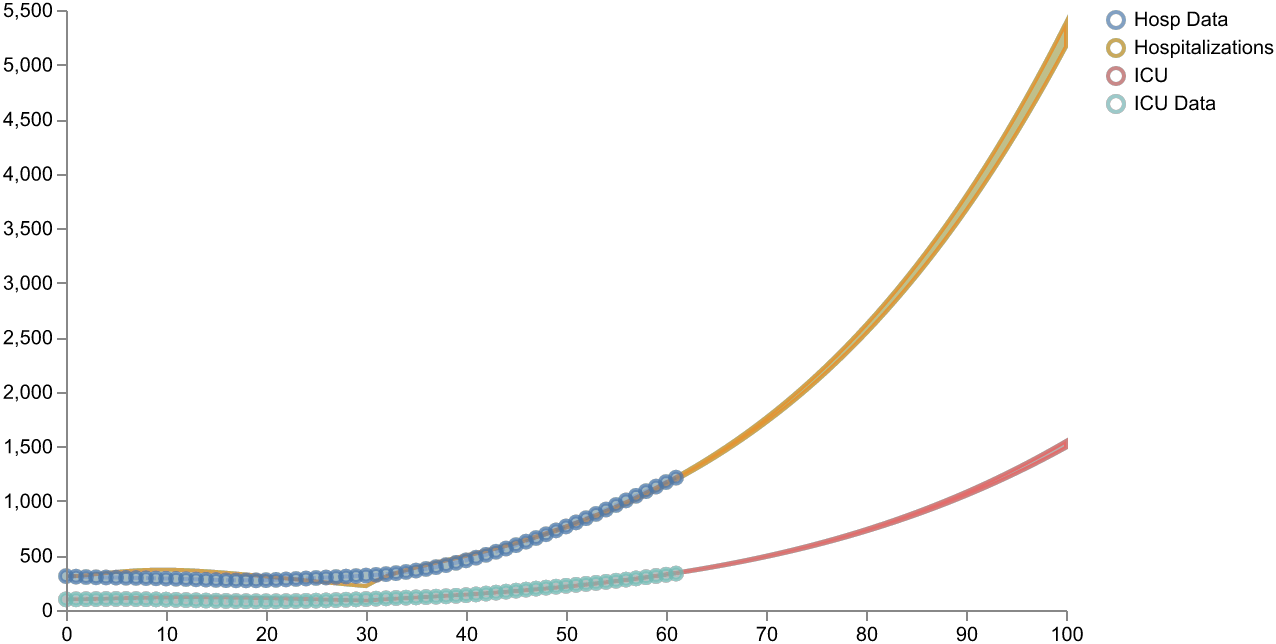

In [86]:
# Plot the result
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations", 
        "icu_observable_state": "ICU",
        }
nice_data_names = {
        "hosp": "Hosp Data",
        "icu": "ICU Data",
        }
data_df = dataset
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(optimized_result["data"]), 
    keep=["hospitalized_observable_state", "icu_observable_state"], 
    relabel=nice_labels,
    points=data_df.drop(columns=['Timestamp', 'dead']).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

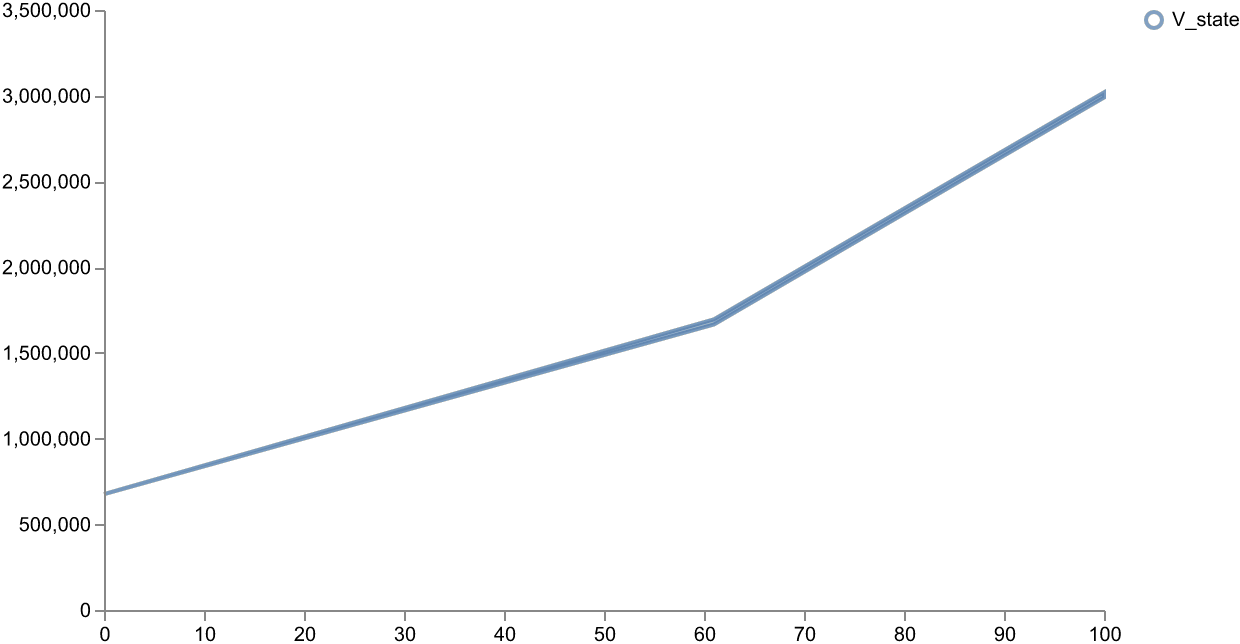

In [87]:
# Plot the result
nice_labels = {
        "V_state": "Vaccinated", 
        }

schema = plots.trajectories(
    pd.DataFrame(optimized_result["data"]), 
    keep=["V_state"], 
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)